# Explore Data


In [16]:
from pathlib import Path

DATA_ROOT = Path("data/EGTEA")

ACTION_ANNOTATION_DIR = DATA_ROOT / "action_annotation"
GAZE_DATA_DIR = DATA_ROOT / "gaze_data"
VIDEO_CLIPS_DIR = DATA_ROOT / "video_clips/cropped_clips"

In [4]:
print("annotations:", ACTION_ANNOTATION_DIR.exists(), ACTION_ANNOTATION_DIR)
print("gaze:", GAZE_DATA_DIR.exists(), GAZE_DATA_DIR)
print("videos:", VIDEO_CLIPS_DIR.exists(), VIDEO_CLIPS_DIR)

print("some annotation files:", list(ACTION_ANNOTATION_DIR.glob("*"))[:10])
print("some gaze files:", list(GAZE_DATA_DIR.rglob("*"))[:10])
print("some videos:", list(VIDEO_CLIPS_DIR.rglob("*.mp4"))[:10])


annotations: True data\EGTEA\action_annotation
gaze: True data\EGTEA\gaze_data
videos: True data\EGTEA\video_clips
some annotation files: [WindowsPath('data/EGTEA/action_annotation/action_annotation_readme.md'), WindowsPath('data/EGTEA/action_annotation/action_idx.txt'), WindowsPath('data/EGTEA/action_annotation/noun_idx.txt'), WindowsPath('data/EGTEA/action_annotation/raw_annotations'), WindowsPath('data/EGTEA/action_annotation/test_split1.txt'), WindowsPath('data/EGTEA/action_annotation/test_split2.txt'), WindowsPath('data/EGTEA/action_annotation/test_split3.txt'), WindowsPath('data/EGTEA/action_annotation/train_split1.txt'), WindowsPath('data/EGTEA/action_annotation/train_split2.txt'), WindowsPath('data/EGTEA/action_annotation/train_split3.txt')]
some gaze files: [WindowsPath('data/EGTEA/gaze_data/OP01-R01-PastaSalad.txt'), WindowsPath('data/EGTEA/gaze_data/OP01-R02-TurkeySandwich.txt'), WindowsPath('data/EGTEA/gaze_data/OP01-R03-BaconAndEggs.txt'), WindowsPath('data/EGTEA/gaze_data

In [5]:
import random

videos = list(VIDEO_CLIPS_DIR.rglob("*.mp4"))
assert len(videos) > 0, "No .mp4 files found in VIDEO_CLIPS_DIR"

vid = random.choice(videos)
print("picked video:", vid)


picked video: data\EGTEA\video_clips\cropped_clips\OP03-R07-Pizza\OP03-R07-Pizza-298959-302037-F007168-F007256.mp4


In [6]:
from pathlib import Path

session_key = "P02-R04-ContinentalBreakfast"

cands = sorted([
    p for p in GAZE_DATA_DIR.rglob(f"*{session_key}*")
    if p.is_file() and p.suffix.lower() in [".txt", ".csv", ".tsv"]
])

print("cands:", len(cands))
for p in cands[:50]:
    print(" ", p)


cands: 2
  data\EGTEA\gaze_data\OP02-R04-ContinentalBreakfast.txt
  data\EGTEA\gaze_data\P02-R04-ContinentalBreakfast.txt


In [7]:
from pathlib import Path
import pandas as pd

gaze_path = GAZE_DATA_DIR/ "P02-R04-ContinentalBreakfast.txt"

# Read raw lines first
with open(gaze_path, "r") as f:
    lines = f.readlines()

print("first 50 lines:")
for i in range(50):
    print(i, lines[i].strip())


first 50 lines:
0 ## [BeGaze]
1 ## Converted from:	E:\Aware HOme\aware home recording unit 11-17\AwareHomeGazeStudy-RecordingUnit\p2r4-[763e43e8-80e9-4d99-9be2-5c634275e01a]\p2r4-1-unified.smi
2 ## Date:	04.11.2015 10:37:04
3 ## Version:	BeGaze 3.4.46
4 ## IDF Version:	10
5 ## Sample Rate:	30
6 ## Separator Type:	Trial
7 ## Trial Count:	1
8 ## Uses Plane File:	False
9 ## Stimulus:	p2r4-1-recording.avi
10 ## Number of Samples:	40356
11 ## Reversed:	none
12 ## [Run]
13 ## Subject:	p2r4-1-unified
14 ## Description:	Run017
15 ## [Calibration]
16 ## Calibration Area:	1280	960
17 ## [Geometry]
18 ## Stimulus Dimension [mm]:	1280	960
19 ## Head Distance [mm]:	1450
20 ## [Hardware Setup]
21 ## System ID:
22 ## Operating System :
23 ## IView X Version:
24 ## [Filter Settings]
25 ## Heuristics:	False
26 ## Heuristics Stage:	0
27 ## Bilateral:	False
28 ## Gaze Cursor Filter:	False
29 ## Saccade Length [px]:	0
30 ## Filter Depth [ms]:	0
31 ## Format:	LEFT, RIGHT, POR, AOI, EYEPOSITION, GAZEVECTOR,

In [17]:
# ===== (2) Parse the clip metadata from the filename =====
import re
from pathlib import Path

vid = VIDEO_CLIPS_DIR/"P02-R04-ContinentalBreakfast/P02-R04-ContinentalBreakfast-544830-552337-F013057-F013275.mp4"

m = re.search(r"-(\d+)-(\d+)-F(\d+)-F(\d+)$", vid.stem)
t0_ms, t1_ms, f0, f1 = map(int, m.groups())

print("t0_ms,t1_ms,f0,f1:", t0_ms, t1_ms, f0, f1)
print("clip window seconds:", t0_ms/1000, "to", t1_ms/1000)
print("frame window:", f0, "to", f1, "nframes:", f1 - f0 + 1)


t0_ms,t1_ms,f0,f1: 544830 552337 13057 13275
clip window seconds: 544.83 to 552.337
frame window: 13057 to 13275 nframes: 219


In [9]:
# ===== (3) Load gaze file cleanly + add frame30 + x/y + t_sec =====
import pandas as pd
import numpy as np
from pathlib import Path

# gaze_path = Path("/content/drive/MyDrive/data/gaze cam/gaze_data/gaze_data/P02-R04-ContinentalBreakfast.txt")

gaze = pd.read_csv(
    gaze_path,
    sep="\t",
    skiprows=33,   # works for your file (line 33 is the header)
    header=0
)

def tc_to_frame30(tc: str) -> int:
    # "HH:MM:SS:FF" where FF is the 30Hz frame counter
    hh, mm, ss, ff = str(tc).split(":")
    return (int(hh)*3600 + int(mm)*60 + int(ss))*30 + int(ff)

gaze["frame30"] = gaze["Frame"].apply(tc_to_frame30)

gaze["x"] = pd.to_numeric(gaze["B POR X [px]"], errors="coerce")
gaze["y"] = pd.to_numeric(gaze["B POR Y [px]"], errors="coerce")

# time origin (Time is in microseconds in your file)
t_base_us = gaze["Time"].iloc[0]
gaze["t_sec"] = (gaze["Time"] - t_base_us) / 1e6

# quick sanity on sample interval (should be ~0.033s median at 30Hz)
dt = gaze["Time"].diff().dropna()
print("gaze shape:", gaze.shape)
print("median dt (us):", float(np.median(dt)))
print("median dt (sec):", float(np.median(dt))/1e6)
print(gaze[["Time","t_sec","Frame","frame30","x","y"]].head())


gaze shape: (40356, 31)
median dt (us): 33264.0
median dt (sec): 0.033264
        Time     t_sec        Frame  frame30       x        y
0  158685455  0.000000  00:00:00:00        0  414.77  1374.09
1  158718811  0.033356  00:00:00:01        1  435.53   523.12
2  158752075  0.066620  00:00:00:02        2  526.82   891.95
3  158785339  0.099884  00:00:00:03        3  436.68   526.92
4  158818634  0.133179  00:00:00:03        3  492.85   723.73


In [10]:
# ===== (4) Slice gaze using frame IDs + overlay on clip frames =====
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Known rates
video_fps = 24.0
gaze_hz = 30.0

# Convert session video frame IDs -> gaze indices
g0 = int(round(f0 * (gaze_hz / video_fps)))
g1 = int(round(f1 * (gaze_hz / video_fps)))

print("gaze idx range:", g0, g1, "ngaze:", g1 - g0 + 1)

# slice gaze rows
g_clip = gaze.iloc[g0:g1+1].copy()

# clean x/y
g_clip["x"] = pd.to_numeric(g_clip["B POR X [px]"], errors="coerce")
g_clip["y"] = pd.to_numeric(g_clip["B POR Y [px]"], errors="coerce")
g_clip = g_clip.dropna(subset=["x","y"])

print("g_clip rows:", len(g_clip))
print(g_clip[["Frame","x","y"]].head())

cap = cv2.VideoCapture(str(vid))
fps = cap.get(cv2.CAP_PROP_FPS)
print("clip fps:", fps)

cal_w, cal_h = 1280, 960

# overlay gaze on clip frames
for i in [0, 10, 30, 60, 100]:
    cap.set(cv2.CAP_PROP_POS_FRAMES, i)
    ok, frame = cap.read()
    if not ok:
        continue

    h, w = frame.shape[:2]

    session_f = f0 + i
    gi = int(round(session_f * (gaze_hz / video_fps))) - g0
    gi = int(np.clip(gi, 0, len(g_clip) - 1))

    x = float(g_clip.iloc[gi]["x"])
    y = float(g_clip.iloc[gi]["y"])

    # rescale from calibration size
    x = x * (w / cal_w)
    y = y * (h / cal_h)

    x = int(np.clip(round(x), 0, w-1))
    y = int(np.clip(round(y), 0, h-1))

    frame = cv2.circle(frame, (x, y), 8, (0,255,0), -1)

    plt.figure(figsize=(6,4))
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.title(f"clip frame {i}")
    plt.axis("off")
    plt.show()


gaze idx range: 16321 16594 ngaze: 274
g_clip rows: 270
             Frame       x       y
16321  00:09:03:05  714.14  505.68
16322  00:09:03:06  710.18  510.22
16323  00:09:03:06  711.25  520.64
16324  00:09:03:07  710.27  526.00
16325  00:09:03:08  709.28  532.74
clip fps: 0.0


In [11]:
cal_w, cal_h = 1280, 960  # from header

def gaze_xy_for_clip_frame(i, frame_w, frame_h):
    session_f = f0 + i
    gi = int(round(session_f * (gaze_hz / video_fps)))
    gi = int(np.clip(gi, 0, len(gaze)-1))

    x = float(gaze.iloc[gi]["B POR X [px]"])
    y = float(gaze.iloc[gi]["B POR Y [px]"])

    # invalid sample
    if not (0 <= x <= cal_w and 0 <= y <= cal_h):
        return None

    # rescale to clip resolution
    x = x * (frame_w / cal_w)
    y = y * (frame_h / cal_h)

    return int(round(x)), int(round(y))


In [12]:
cal_w, cal_h = 1280, 960
valid = (g_clip["x"].between(0, cal_w) &
         g_clip["y"].between(0, cal_h))

print("valid gaze %:", valid.mean())


valid gaze %: 0.9925925925925926


In [13]:
# =========================
# TODO
# =========================

# TODO: load pretrained action model
# TODO: implement video preprocessing (clip -> model input)
# TODO: run inference on one clip
# TODO: print ground truth vs prediction

# TODO: implement Grad-CAM
# TODO: generate saliency map per frame

# TODO: compute saliency value at gaze point
# TODO: average alignment per clip

# TODO: compare alignment for correct vs incorrect clips

# TODO: implement temporal shift (+/- frames)
# TODO: test lead vs lag effect

# TODO: add one alternative saliency method (occlusion or attention rollout)

# TODO: make plots for results


In [18]:
# ===============================
# Baseline Action Prediction Cell
# R3D-18 (Kinetics-400) + OpenCV decode
# No torchvision video decoding, no weights.transforms()
# ===============================

# !pip install -q opencv-python

import cv2
import torch
import numpy as np
import torch.nn.functional as F
from torchvision.models.video import r3d_18, R3D_18_Weights

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

# -------------------
# Load pretrained model
# -------------------
weights = R3D_18_Weights.DEFAULT
model = r3d_18(weights=weights).to(DEVICE).eval()
KINETICS_CLASSES = weights.meta["categories"]
print("Model loaded.")

# Kinetics normalization constants used by torchvision weights
KINETICS_MEAN = torch.tensor([0.43216, 0.394666, 0.37645]).view(1, 3, 1, 1, 1)
KINETICS_STD  = torch.tensor([0.22803, 0.22145, 0.216989]).view(1, 3, 1, 1, 1)

def _preprocess_video_bcthw(x_bcthw, out_size=112):
    """
    x_bcthw: float tensor in [0,1], shape (B, C, T, H, W)
    returns: normalized tensor, shape (B, C, T, out_size, out_size)
    """
    if x_bcthw.ndim != 5 or x_bcthw.shape[1] != 3:
        raise ValueError(f"Expected (B,3,T,H,W), got {tuple(x_bcthw.shape)}")

    B, C, T, H, W = x_bcthw.shape

    # resize spatial dims with interpolate (works on N,C,H,W)
    x = x_bcthw.permute(0, 2, 1, 3, 4).contiguous()       # (B, T, C, H, W)
    x = x.view(B * T, C, H, W)                             # (B*T, C, H, W)
    x = F.interpolate(x, size=(out_size, out_size), mode="bilinear", align_corners=False)
    x = x.view(B, T, C, out_size, out_size).permute(0, 2, 1, 3, 4).contiguous()  # (B,C,T,H,W)

    # normalize
    mean = KINETICS_MEAN.to(x.device, x.dtype)
    std = KINETICS_STD.to(x.device, x.dtype)
    x = (x - mean) / std
    return x

def load_clip_tensor(clip_path, num_frames=16):
    cap = cv2.VideoCapture(str(clip_path))
    if not cap.isOpened():
        raise ValueError(f"Could not open video: {clip_path}")

    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
    cap.release()

    if len(frames) < 2:
        raise ValueError(f"Too few frames in: {clip_path}")

    frames = np.asarray(frames)  # (T, H, W, 3)
    T = frames.shape[0]

    idx = np.linspace(0, T - 1, num_frames).round().astype(int)
    idx = np.clip(idx, 0, T - 1)
    frames = frames[idx]  # (num_frames, H, W, 3)

    # to tensor (1,3,T,H,W), float [0,1]
    x = torch.from_numpy(frames).to(torch.float32) / 255.0      # (T,H,W,3)
    x = x.permute(3, 0, 1, 2).unsqueeze(0).contiguous()         # (1,3,T,H,W)

    x = _preprocess_video_bcthw(x, out_size=112)
    return x.to(DEVICE), {"orig_T": int(T), "sampled_T": int(num_frames)}

@torch.inference_mode()
def predict_clip(clip_path, topk=5):
    x, dbg = load_clip_tensor(clip_path, num_frames=16)
    logits = model(x)                    # (1, 400)
    probs = torch.softmax(logits, dim=1)[0]

    pred_idx = int(torch.argmax(probs).item())
    pred_prob = float(probs[pred_idx].item())
    pred_label = KINETICS_CLASSES[pred_idx]

    top_probs, top_idxs = torch.topk(probs, k=topk)
    top = [(KINETICS_CLASSES[int(i)], float(p)) for p, i in zip(top_probs.cpu().tolist(), top_idxs.cpu().tolist())]

    return {
        "clip_path": str(clip_path),
        "pred_idx": pred_idx,
        "pred_label": pred_label,
        "pred_prob": pred_prob,
        "topk": top,
        "debug": dbg,
    }

# ---- smoke test on your existing 'vid' Path ----
pred = predict_clip(vid, topk=5)
print("\nClip:", pred["clip_path"])
print("Prediction:", pred["pred_label"], "| prob:", pred["pred_prob"])
print("\nTop-5:")
for lbl, p in pred["topk"]:
    print(f"{p:0.4f}  {lbl}")
print("\nDebug:", pred["debug"])


Using device: cpu
Model loaded.

Clip: data\EGTEA\video_clips\cropped_clips\P02-R04-ContinentalBreakfast\P02-R04-ContinentalBreakfast-544830-552337-F013057-F013275.mp4
Prediction: cooking egg | prob: 0.18337282538414001

Top-5:
0.1834  cooking egg
0.0804  sharpening pencil
0.0803  making jewelry
0.0576  playing controller
0.0433  cleaning shoes

Debug: {'orig_T': 219, 'sampled_T': 16}


In [19]:
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm

CLIPS_ROOT = Path("data/EGTEA/video_clips/cropped_clips")
OUT_CSV = Path("data/EGTEA/preds_kinetics_r3d18.csv")

def list_mp4s(root: Path):
    return sorted(root.rglob("*.mp4"))

def batch_predict(clips, topk=5, max_clips=100):
    rows = []
    for p in tqdm(clips[:max_clips], desc="Predicting clips"):
        try:
            pred = predict_clip(p, topk=topk)
            rows.append({
                "clip_path": pred["clip_path"],
                "pred_idx": pred["pred_idx"],
                "pred_label": pred["pred_label"],
                "pred_prob": pred["pred_prob"],
                "topk": pred["topk"],          # list of tuples
                "orig_T": pred["debug"]["orig_T"],
                "sampled_T": pred["debug"]["sampled_T"],
            })
        except Exception as e:
            rows.append({
                "clip_path": str(p),
                "error": repr(e),
            })
    return pd.DataFrame(rows)

clips = list_mp4s(CLIPS_ROOT)
print("Found mp4 clips:", len(clips))
print("Example:", clips[0] if clips else None)

df_preds = batch_predict(clips, topk=5, max_clips=200)

# Expand topk into separate columns (top1..top5 labels/probs)
def unpack_topk(row, k=5):
    top = row.get("topk", None)
    if not isinstance(top, list):
        return {}
    out = {}
    for i in range(min(k, len(top))):
        lbl, p = top[i]
        out[f"top{i+1}_label"] = lbl
        out[f"top{i+1}_prob"] = p
    return out

topk_expanded = df_preds.apply(lambda r: pd.Series(unpack_topk(r, 5)), axis=1)
df_preds = pd.concat([df_preds.drop(columns=["topk"], errors="ignore"), topk_expanded], axis=1)

df_preds.to_csv(OUT_CSV, index=False)
print("Saved:", OUT_CSV)

print("\nSummary:")
print(df_preds[["pred_label","pred_prob"]].dropna().head(10))
print("\nErrors:", int(df_preds["error"].notna().sum()) if "error" in df_preds else 0)


c:\Users\maya\gsoc\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Found mp4 clips: 15484
Example: data\EGTEA\video_clips\cropped_clips\OP01-R01-PastaSalad\OP01-R01-PastaSalad-1002316-1004005-F024051-F024101.mp4


Predicting clips: 100%|██████████| 200/200 [00:58<00:00,  3.44it/s]

Saved: data\EGTEA\preds_kinetics_r3d18.csv

Summary:
          pred_label  pred_prob
0  frying vegetables   0.424271
1    recording music   0.154434
2        cooking egg   0.463573
3      doing laundry   0.211021
4        cooking egg   0.425217
5   flipping pancake   0.341995
6      doing laundry   0.266364
7   flipping pancake   0.220724
8        cooking egg   0.662831
9   flipping pancake   0.506599

Errors: 0


In [20]:
!ls -lah "data/EGTEA/action_annotation"
!find "data/EGTEA/action_annotation" -maxdepth 2 -type f | head -n 50


'ls' is not recognized as an internal or external command,
operable program or batch file.
'head' is not recognized as an internal or external command,
operable program or batch file.


In [22]:
!pip install -q opencv-python pandas tqdm

In [32]:
# ===============================
# EGTEA fine-tune R3D-18 on ACTION labels (split1 by default)
# Uses your cropped clips + raw_annotations/action_labels.csv
# ===============================


import re
import cv2
import math
import time
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision.models.video import r3d_18, R3D_18_Weights

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

# -----------------------
# Paths
# -----------------------
CLIPS_ROOT = Path("data/EGTEA/video_clips/cropped_clips")
ANN_ROOT   = Path("data/EGTEA/action_annotation")
RAW_ANN    = ANN_ROOT / "raw_annotations" / "action_labels.csv"
ACTION_IDX = ANN_ROOT / "action_idx.txt"

# Choose split (1,2,3)
SPLIT = 1
TRAIN_SPLIT = ANN_ROOT / f"train_split{SPLIT}.txt"
TEST_SPLIT  = ANN_ROOT / f"test_split{SPLIT}.txt"

# Training params (keep small first to verify)
NUM_FRAMES = 16
INPUT_SIZE = 112
BATCH_SIZE = 8
EPOCHS = 2
LR = 3e-4
NUM_WORKERS = 2

OUT_WEIGHTS = Path(f"/content/drive/MyDrive/data/gaze cam/r3d18_egtea_action_split{SPLIT}.pt")

# -----------------------
# Helpers: parse your clip filenames
# Example:
# P02-R04-ContinentalBreakfast-544830-552337-F013057-F013275.mp4
# -----------------------
clip_pat = re.compile(r"^(?P<vid>.+?)-(?P<t0>\d+)-(?P<t1>\d+)-F(?P<f0>\d+)-F(?P<f1>\d+)$")

def parse_clip_stem(clip_path: Path):
    m = clip_pat.match(clip_path.stem)
    if not m:
        return None
    d = m.groupdict()
    return {
        "video_id": d["vid"],
        "t0": int(d["t0"]),
        "t1": int(d["t1"]),
        "f0": int(d["f0"]),
        "f1": int(d["f1"]),
    }

# -----------------------
# Load action_idx mapping (id -> name)
# -----------------------
def load_idx_file(path: Path):
    # Usually lines like: "0 take"
    out = {}
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split()
            try:
                idx = int(parts[0])
                name = " ".join(parts[1:]) if len(parts) > 1 else str(idx)
                out[idx] = name
            except:
                continue
    return out

ACTION_ID_TO_NAME = load_idx_file(ACTION_IDX)

# -----------------------
# Load raw action labels with timing
# -----------------------
df_ann = pd.read_csv(RAW_ANN, sep=";", engine="python")
df_ann.columns = [c.strip() for c in df_ann.columns]

df_ann = df_ann.rename(columns={
    "Clip Prefix (Unique)": "clip_prefix",
    "Video Session": "video_id",
    "Starting Time (ms)": "t0_ms",
    "Ending Time (ms)": "t1_ms",
    "Action Label": "action_label",
})

df_ann["t0_ms"] = df_ann["t0_ms"].astype(int)
df_ann["t1_ms"] = df_ann["t1_ms"].astype(int)

# numeric label for training
df_ann["action_id"] = df_ann["action_label"].astype("category").cat.codes
NUM_ACTIONS = df_ann["action_id"].nunique()

ann_by_vid = {k: g.sort_values("t0_ms").reset_index(drop=True) for k, g in df_ann.groupby("video_id")}
print("NUM_ACTIONS:", NUM_ACTIONS)

# df_ann = pd.read_csv(RAW_ANN, sep=";", engine="python")
# # Try to normalize column names a bit
# df_ann.columns = [c.strip() for c in df_ann.columns]

# We need: video_id + start/end frame + action id
# EGTEA formats vary; handle common variants
col_vid = None
for c in ["video_id", "video", "clip", "sequence", "name"]:
    if c in df_ann.columns:
        col_vid = c
        break
if col_vid is None:
    raise ValueError(f"Couldn't find video id column in {RAW_ANN}. Columns={list(df_ann.columns)}")

col_sf = None
for c in ["start_frame", "start", "startFrame", "frame_start", "start_f"]:
    if c in df_ann.columns:
        col_sf = c
        break
col_ef = None
for c in ["end_frame", "end", "endFrame", "frame_end", "end_f"]:
    if c in df_ann.columns:
        col_ef = c
        break

# action id column
col_action = None
for c in ["action", "action_id", "action_idx", "cls", "class", "label"]:
    if c in df_ann.columns:
        col_action = c
        break

if col_sf is None or col_ef is None or col_action is None:
    raise ValueError(
        f"Missing needed columns in action_labels.csv.\n"
        f"Found cols={list(df_ann.columns)}\n"
        f"Need video_id + start_frame + end_frame + action_id"
    )

df_ann = df_ann.rename(columns={col_vid: "video_id", col_sf: "start_frame", col_ef: "end_frame", col_action: "action_id"})
df_ann["start_frame"] = df_ann["start_frame"].astype(int)
df_ann["end_frame"]   = df_ann["end_frame"].astype(int)
df_ann["action_id"]   = df_ann["action_id"].astype(int)

# Build per-video group for fast lookup
ann_by_vid = {k: g.sort_values("start_frame").reset_index(drop=True) for k, g in df_ann.groupby("video_id")}

# Determine number of action classes (safe)
NUM_ACTIONS = int(df_ann["action_id"].max()) + 1
print("NUM_ACTIONS:", NUM_ACTIONS)

# -----------------------
# Read split file: keep only video_ids included
# We don't assume exact format; just take the first token as video_id.
# -----------------------
def load_split_video_ids(split_path: Path):
    vids = set()
    with open(split_path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            tok = line.split()[0]
            # Sometimes split lines include extensions; strip
            tok = tok.replace(".mp4", "").replace(".avi", "")
            vids.add(tok)
    return vids

train_vids = load_split_video_ids(TRAIN_SPLIT)
test_vids  = load_split_video_ids(TEST_SPLIT)
print("Train vids:", len(train_vids), "Test vids:", len(test_vids))

# -----------------------
# Match a cropped clip window (f0,f1) to an action segment by overlap
# -----------------------
def match_action_id(video_id: str, f0: int, f1: int):
    g = ann_by_vid.get(video_id, None)
    if g is None or len(g) == 0:
        return None

    # compute overlap with each segment
    sf = g["start_frame"].to_numpy()
    ef = g["end_frame"].to_numpy()
    overlap = np.maximum(0, np.minimum(f1, ef) - np.maximum(f0, sf))
    best = int(np.argmax(overlap))
    if overlap[best] <= 0:
        return None
    return int(g.iloc[best]["action_id"])

# -----------------------
# Video decoding + preprocessing (same as your working baseline)
# -----------------------
KINETICS_MEAN = torch.tensor([0.43216, 0.394666, 0.37645]).view(1, 3, 1, 1, 1)
KINETICS_STD  = torch.tensor([0.22803, 0.22145, 0.216989]).view(1, 3, 1, 1, 1)

def preprocess_bcthw(x_bcthw, out_size=112):
    B, C, T, H, W = x_bcthw.shape
    x = x_bcthw.permute(0, 2, 1, 3, 4).contiguous().view(B*T, C, H, W)
    x = F.interpolate(x, size=(out_size, out_size), mode="bilinear", align_corners=False)
    x = x.view(B, T, C, out_size, out_size).permute(0, 2, 1, 3, 4).contiguous()

    mean = KINETICS_MEAN.to(x.device, x.dtype)
    std  = KINETICS_STD.to(x.device, x.dtype)
    return (x - mean) / std

def load_clip_tensor_opencv(clip_path, num_frames=16):
    cap = cv2.VideoCapture(str(clip_path))
    if not cap.isOpened():
        raise ValueError(f"Could not open video: {clip_path}")

    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
    cap.release()

    if len(frames) < 2:
        raise ValueError(f"Too few frames in: {clip_path}")

    frames = np.asarray(frames)  # (T,H,W,3)
    T = frames.shape[0]
    idx = np.linspace(0, T - 1, num_frames).round().astype(int)
    idx = np.clip(idx, 0, T - 1)
    frames = frames[idx]

    x = torch.from_numpy(frames).float() / 255.0  # (T,H,W,3)
    x = x.permute(3, 0, 1, 2).unsqueeze(0).contiguous()  # (1,3,T,H,W)
    x = preprocess_bcthw(x, out_size=INPUT_SIZE)
    return x[0], {"orig_T": int(T)}  # return (3,T,H,W) for Dataset

# -----------------------
# Dataset: cropped clips -> action_id
# -----------------------
class EGTEACroppedActionDataset(Dataset):
    def __init__(self, clips_root: Path, allowed_vids: set, max_items=None):
        self.items = []
        for mp4 in sorted(clips_root.rglob("*.mp4")):
            meta = parse_clip_stem(mp4)
            if meta is None:
                continue
            if meta["video_id"] not in allowed_vids:
                continue

            aid = match_action_id(meta["video_id"], meta["f0"], meta["f1"])
            if aid is None:
                continue

            self.items.append((mp4, aid, meta))
            if max_items is not None and len(self.items) >= max_items:
                break

        if len(self.items) == 0:
            raise ValueError("No training items found. Likely video_id naming mismatch between clips and annotations.")

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        p, aid, meta = self.items[idx]
        x, dbg = load_clip_tensor_opencv(p, num_frames=NUM_FRAMES)  # (3,T,H,W)
        y = torch.tensor(aid, dtype=torch.long)
        return x, y, str(p), meta

# Keep small while debugging; remove max_items later
train_ds = EGTEACroppedActionDataset(CLIPS_ROOT, train_vids, max_items=2000)
test_ds  = EGTEACroppedActionDataset(CLIPS_ROOT, test_vids,  max_items=500)

print("Train items:", len(train_ds), "Test items:", len(test_ds))

# Quick sanity print
for i in range(3):
    _, y, p, meta = train_ds[i]
    print(i, Path(p).name, "-> action_id", int(y), "name:", ACTION_ID_TO_NAME.get(int(y), "<?>"), "meta:", meta)

def collate(batch):
    xs, ys, paths, metas = zip(*batch)
    x = torch.stack(xs, dim=0)  # (B,3,T,H,W)
    y = torch.stack(ys, dim=0)
    return x, y, list(paths), list(metas)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True, collate_fn=collate)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True, collate_fn=collate)

# -----------------------
# Model: R3D-18 backbone + new EGTEA head
# -----------------------
weights = R3D_18_Weights.DEFAULT
model = r3d_18(weights=weights)
model.fc = nn.Linear(model.fc.in_features, NUM_ACTIONS)
model = model.to(DEVICE)

opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)

@torch.inference_mode()
def eval_top1(loader):
    model.eval()
    correct = 0
    total = 0
    for x, y, _, _ in loader:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)
        logits = model(x)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.numel()
    return correct / max(1, total)

# -----------------------
# Train loop
# -----------------------
print("\nStarting training...")
for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    seen = 0

    for x, y, _, _ in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}"):
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)

        logits = model(x)
        loss = F.cross_entropy(logits, y)

        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()

        running_loss += loss.item() * y.size(0)
        seen += y.size(0)

    train_loss = running_loss / max(1, seen)
    acc = eval_top1(test_loader)

    print(f"Epoch {epoch}: train_loss={train_loss:.4f}  test_top1={acc:.4f}")

torch.save({
    "model_state": model.state_dict(),
    "num_actions": NUM_ACTIONS,
    "split": SPLIT,
    "num_frames": NUM_FRAMES,
    "input_size": INPUT_SIZE,
}, OUT_WEIGHTS)

print("Saved:", OUT_WEIGHTS)


Using device: cpu
NUM_ACTIONS: 1170


ValueError: Missing needed columns in action_labels.csv.
Found cols=['# Clip ID (Unique, used only internally)', 'clip_prefix', 'video_id', 't0_ms', 't1_ms', 'action_label', 'Verb Label', 'Noun Label(s)', 'action_id']
Need video_id + start_frame + end_frame + action_id

In [36]:
# ===============================
# EGTEA fine-tune R3D-18 on ACTION labels (Split 1 by default)
# - action_labels.csv is semicolon-separated AND has spaces after semicolons
# - Split files contain FULL clip stems: vid-t0-t1-Ff0-Ff1
# - Raw annotations contain clip_prefix: vid-t0-t1 (NO -F...)
# - Labeling:
#     1) exact match by (video_id, clip_prefix)
#     2) fallback time-overlap
# ===============================

import re
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models.video import r3d_18, R3D_18_Weights

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

# -----------------------
# Paths
# -----------------------
CLIPS_ROOT = Path("data/EGTEA/video_clips/cropped_clips")
ANN_ROOT   = Path("data/EGTEA/action_annotation")
RAW_ANN    = ANN_ROOT / "raw_annotations" / "action_labels.csv"

SPLIT = 1
TRAIN_SPLIT = ANN_ROOT / f"train_split{SPLIT}.txt"
TEST_SPLIT  = ANN_ROOT / f"test_split{SPLIT}.txt"

# Training params
NUM_FRAMES = 16
INPUT_SIZE = 112
BATCH_SIZE = 8
EPOCHS = 2
LR = 3e-4
NUM_WORKERS = 0  # safest on Windows
OUT_WEIGHTS = Path(f"r3d18_egtea_action_split{SPLIT}.pt")

# -----------------------
# Parse cropped clip filename
# Example stem: OP01-R01-PastaSalad-1022590-1024050-F024539-F024581
# -----------------------
clip_pat = re.compile(r"^(?P<vid>.+?)-(?P<t0>\d+)-(?P<t1>\d+)-F(?P<f0>\d+)-F(?P<f1>\d+)$")

def parse_clip_stem(clip_path: Path):
    m = clip_pat.match(clip_path.stem)
    if not m:
        return None
    d = m.groupdict()
    video_id = d["vid"]
    t0 = int(d["t0"])
    t1 = int(d["t1"])
    return {
        "video_id": video_id,
        "t0": t0,
        "t1": t1,
        "f0": int(d["f0"]),
        "f1": int(d["f1"]),
        # Raw annotation clip_prefix format (NO -F...)
        "clip_prefix": f"{video_id}-{t0}-{t1}",
    }

# -----------------------
# Load raw action labels (semicolon separated)
# CRITICAL: handle spaces after semicolons
# -----------------------
if not RAW_ANN.exists():
    raise FileNotFoundError(f"RAW_ANN not found: {RAW_ANN}")

df_ann = pd.read_csv(RAW_ANN, sep=";", engine="python", skipinitialspace=True)
df_ann.columns = [c.strip() for c in df_ann.columns]

required = ["Clip Prefix (Unique)", "Video Session", "Starting Time (ms)", "Ending Time (ms)", "Action Label"]
for c in required:
    if c not in df_ann.columns:
        raise ValueError(f"Missing column '{c}'. Have: {list(df_ann.columns)}")

df_ann = df_ann.rename(columns={
    "Clip Prefix (Unique)": "clip_prefix",
    "Video Session": "video_id",
    "Starting Time (ms)": "t0_ms",
    "Ending Time (ms)": "t1_ms",
    "Action Label": "action_label",
})

# Strip whitespace in string fields (THIS FIXES YOUR ISSUE)
for c in ["clip_prefix", "video_id", "action_label"]:
    df_ann[c] = df_ann[c].astype(str).str.strip()

df_ann["t0_ms"] = df_ann["t0_ms"].astype(int)
df_ann["t1_ms"] = df_ann["t1_ms"].astype(int)

# Numeric IDs for training
df_ann["action_id"] = df_ann["action_label"].astype("category").cat.codes
action_categories = list(df_ann["action_label"].astype("category").cat.categories)
NUM_ACTIONS = int(df_ann["action_id"].nunique())
print("NUM_ACTIONS:", NUM_ACTIONS)

# Exact lookup map
ann_exact = {(row["video_id"], row["clip_prefix"]): int(row["action_id"]) for _, row in df_ann.iterrows()}

# Per-video groups for overlap fallback
ann_by_vid = {vid: g.sort_values("t0_ms").reset_index(drop=True) for vid, g in df_ann.groupby("video_id")}

def action_name_from_id(aid: int) -> str:
    return action_categories[aid] if 0 <= aid < len(action_categories) else str(aid)

# -----------------------
# Split: load FULL stems (with -F...)
# -----------------------
def load_split_clip_stems(split_path: Path):
    if not split_path.exists():
        raise FileNotFoundError(f"Split file not found: {split_path}")
    s = set()
    with open(split_path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            tok = line.split()[0].replace(".mp4", "").replace(".avi", "")
            s.add(tok)
    return s

train_stems = load_split_clip_stems(TRAIN_SPLIT)
test_stems  = load_split_clip_stems(TEST_SPLIT)
print("Train stems:", len(train_stems), "Test stems:", len(test_stems))

# -----------------------
# Match label for a clip:
#  1) exact match on (video_id, clip_prefix)
#  2) fallback overlap
# -----------------------
def match_action_id(meta):
    video_id = meta["video_id"]
    clip_prefix = meta["clip_prefix"]
    t0 = meta["t0"]
    t1 = meta["t1"]

    key = (video_id, clip_prefix)
    if key in ann_exact:
        return ann_exact[key]

    g = ann_by_vid.get(video_id, None)
    if g is None or len(g) == 0:
        return None

    a0 = g["t0_ms"].to_numpy()
    a1 = g["t1_ms"].to_numpy()
    overlap = np.maximum(0, np.minimum(t1, a1) - np.maximum(t0, a0))
    best = int(np.argmax(overlap))
    if overlap[best] <= 0:
        return None
    return int(g.iloc[best]["action_id"])

# -----------------------
# Video decoding + preprocessing
# -----------------------
KINETICS_MEAN = torch.tensor([0.43216, 0.394666, 0.37645]).view(1, 3, 1, 1, 1)
KINETICS_STD  = torch.tensor([0.22803, 0.22145, 0.216989]).view(1, 3, 1, 1, 1)

def preprocess_bcthw(x_bcthw, out_size=112):
    B, C, T, H, W = x_bcthw.shape
    x = x_bcthw.permute(0, 2, 1, 3, 4).contiguous().view(B*T, C, H, W)
    x = F.interpolate(x, size=(out_size, out_size), mode="bilinear", align_corners=False)
    x = x.view(B, T, C, out_size, out_size).permute(0, 2, 1, 3, 4).contiguous()
    mean = KINETICS_MEAN.to(x.device, x.dtype)
    std  = KINETICS_STD.to(x.device, x.dtype)
    return (x - mean) / std

def load_clip_tensor_opencv(clip_path, num_frames=16):
    cap = cv2.VideoCapture(str(clip_path))
    if not cap.isOpened():
        raise ValueError(f"Could not open video: {clip_path}")

    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
    cap.release()

    if len(frames) < 2:
        raise ValueError(f"Too few frames in: {clip_path}")

    frames = np.asarray(frames)
    T = frames.shape[0]
    idx = np.linspace(0, T - 1, num_frames).round().astype(int)
    idx = np.clip(idx, 0, T - 1)
    frames = frames[idx]

    x = torch.from_numpy(frames).float() / 255.0
    x = x.permute(3, 0, 1, 2).unsqueeze(0).contiguous()  # (1,3,T,H,W)
    x = preprocess_bcthw(x, out_size=INPUT_SIZE)
    return x[0]  # (3,T,H,W)

# -----------------------
# Dataset
# -----------------------
class EGTEACroppedActionDataset(Dataset):
    def __init__(self, clips_root: Path, allowed_stems: set, max_items=None):
        self.items = []
        for mp4 in sorted(clips_root.rglob("*.mp4")):
            if mp4.stem not in allowed_stems:
                continue

            meta = parse_clip_stem(mp4)
            if meta is None:
                continue

            aid = match_action_id(meta)
            if aid is None:
                continue

            self.items.append((mp4, aid, meta))
            if max_items is not None and len(self.items) >= max_items:
                break

        if len(self.items) == 0:
            some_mp4 = [p.stem for p in sorted(clips_root.rglob("*.mp4"))[:10]]
            some_split = list(sorted(allowed_stems))[:10]
            raise ValueError(
                "No training items found.\n"
                "Split ↔ mp4 stems match, so labeling failed.\n"
                f"Example mp4 stems: {some_mp4}\n"
                f"Example split stems: {some_split}\n"
                "Most common cause: leading spaces in annotation values. (This code strips them.)"
            )

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        p, aid, meta = self.items[idx]
        x = load_clip_tensor_opencv(p, num_frames=NUM_FRAMES)
        y = torch.tensor(aid, dtype=torch.long)
        return x, y, str(p), meta

def collate(batch):
    xs, ys, paths, metas = zip(*batch)
    x = torch.stack(xs, dim=0)
    y = torch.stack(ys, dim=0)
    return x, y, list(paths), list(metas)

# -----------------------
# Build datasets/loaders
# -----------------------
train_ds = EGTEACroppedActionDataset(CLIPS_ROOT, train_stems, max_items=2000)
test_ds  = EGTEACroppedActionDataset(CLIPS_ROOT, test_stems,  max_items=500)

print("Train items:", len(train_ds), "Test items:", len(test_ds))
for i in range(min(3, len(train_ds))):
    _, y, p, meta = train_ds[i]
    print(i, Path(p).name, "->", int(y), action_name_from_id(int(y)), "clip_prefix:", meta["clip_prefix"])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=(DEVICE=="cuda"),
                          collate_fn=collate)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=(DEVICE=="cuda"),
                          collate_fn=collate)

# -----------------------
# Model
# -----------------------
weights = R3D_18_Weights.DEFAULT
model = r3d_18(weights=weights)
model.fc = nn.Linear(model.fc.in_features, NUM_ACTIONS)
model = model.to(DEVICE)

opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)

@torch.inference_mode()
def eval_top1(loader):
    model.eval()
    correct = 0
    total = 0
    for x, y, _, _ in loader:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)
        logits = model(x)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.numel()
    return correct / max(1, total)

# -----------------------
# Train loop
# -----------------------
print("\nStarting training...")
for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    seen = 0

    for x, y, _, _ in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}"):
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)

        logits = model(x)
        loss = F.cross_entropy(logits, y)

        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()

        running_loss += loss.item() * y.size(0)
        seen += y.size(0)

    train_loss = running_loss / max(1, seen)
    acc = eval_top1(test_loader)
    print(f"Epoch {epoch}: train_loss={train_loss:.4f}  test_top1={acc:.4f}")

torch.save({
    "model_state": model.state_dict(),
    "num_actions": NUM_ACTIONS,
    "split": SPLIT,
    "num_frames": NUM_FRAMES,
    "input_size": INPUT_SIZE,
    "action_categories": action_categories,
}, OUT_WEIGHTS)

print("Saved:", OUT_WEIGHTS.resolve())


Using device: cpu
NUM_ACTIONS: 1170
Train stems: 8299 Test stems: 2022
Train items: 2000 Test items: 500
0 OP01-R01-PastaSalad-1022590-1024050-F024539-F024581.mp4 -> 630 Put cooking_utensil clip_prefix: OP01-R01-PastaSalad-1022590-1024050
1 OP01-R01-PastaSalad-1029725-1031715-F024708-F024767.mp4 -> 230 Inspect/Read recipe clip_prefix: OP01-R01-PastaSalad-1029725-1031715
2 OP01-R01-PastaSalad-1063805-1064815-F025529-F025558.mp4 -> 811 Take cooking_utensil clip_prefix: OP01-R01-PastaSalad-1063805-1064815

Starting training...


Epoch 1/2: 100%|██████████| 250/250 [11:51<00:00,  2.85s/it]


Epoch 1: train_loss=3.6599  test_top1=0.2340


Epoch 2/2: 100%|██████████| 250/250 [10:53<00:00,  2.62s/it]


Epoch 2: train_loss=2.2938  test_top1=0.3100
Saved: C:\Users\maya\Desktop\mosaic\cv\r3d18_egtea_action_split1.pt


In [42]:
import torch
import torch.nn.functional as F

class GradCAM3D:
    """
    Grad-CAM for 3D CNNs without module backward hooks (avoids inplace/view errors).
    Uses forward hook + tensor.register_hook to capture gradients.
    """
    def __init__(self, model: torch.nn.Module, target_layer: torch.nn.Module):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        self._h_fwd = target_layer.register_forward_hook(self._forward_hook)

    def _forward_hook(self, module, inp, out):
        # out: (B,C,T',H',W')
        self.activations = out
        # capture grad wrt activation tensor
        def _save_grad(g):
            self.gradients = g
        out.register_hook(_save_grad)

    def close(self):
        self._h_fwd.remove()

    @staticmethod
    def _normalize(cam: torch.Tensor) -> torch.Tensor:
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        return cam

    def __call__(self, x: torch.Tensor, class_idx: int | None = None):
        """
        x: (B,3,T,H,W), typically B=1
        Returns:
          cam_tprime: (T',H',W') normalized [0,1] for first sample
          class_idx_used: int
          logits: (B,K)
        """
        assert x.ndim == 5, "Expected input (B,3,T,H,W)"
        self.model.eval()
        self.model.zero_grad(set_to_none=True)

        # Forward
        logits = self.model(x)

        if class_idx is None:
            class_idx = int(logits.argmax(dim=1)[0].item())

        # Backward on that class score
        score = logits[0, class_idx]
        score.backward(retain_graph=False)

        # activations/gradients: (B,C,T',H',W')
        A = self.activations[0]
        G = self.gradients[0]

        # weights: mean grad over (T',H',W')
        w = G.mean(dim=(1,2,3), keepdim=True)  # (C,1,1,1)

        cam = (w * A).sum(dim=0)   # (T',H',W')
        cam = F.relu(cam)
        cam = self._normalize(cam.detach())
        return cam, class_idx, logits.detach()


In [46]:
def clear_all_hooks(module: torch.nn.Module):
    # These are internal dicts used by PyTorch to store hooks
    module._backward_hooks.clear()
    module._backward_pre_hooks.clear()
    module._forward_hooks.clear()
    module._forward_pre_hooks.clear()
    for m in module.modules():
        m._backward_hooks.clear()
        m._backward_pre_hooks.clear()
        m._forward_hooks.clear()
        m._forward_pre_hooks.clear()

clear_all_hooks(model)
print("Cleared hooks.")


Cleared hooks.


In [47]:
target_layer = model.layer4[-1].conv2
cam_extractor = GradCAM3D(model, target_layer)



In [44]:
def upsample_cam_to_input(cam_tprime: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    """
    cam_tprime: (T',H',W')
    x: (1,3,T,H,W)
    returns cam: (T,H,W) aligned to x
    """
    T, H, W = x.shape[2], x.shape[3], x.shape[4]
    cam = F.interpolate(
        cam_tprime[None, None],  # (1,1,T',H',W')
        size=(T, H, W),
        mode="trilinear",
        align_corners=False
    )[0, 0]
    cam = cam.clamp(0, 1)
    return cam

def tensor_clip_to_uint8_frames(x: torch.Tensor, mean, std):
    """
    x: (1,3,T,H,W) normalized
    returns: uint8 frames (T,H,W,3)
    """
    x = x.detach().cpu().clone()
    mean = mean.cpu()
    std = std.cpu()
    x = x * std + mean
    x = x.clamp(0, 1)
    x = x[0].permute(1,2,3,0).numpy()  # (T,H,W,3)
    x = (x * 255.0).round().astype(np.uint8)
    return x

def overlay_cam_on_frame(frame_uint8: np.ndarray, cam_hw: np.ndarray, alpha=0.5):
    """
    frame_uint8: (H,W,3)
    cam_hw: (H,W) in [0,1]
    returns overlay (H,W,3) uint8 (simple red overlay)
    """
    cam = np.clip(cam_hw, 0, 1)
    overlay = frame_uint8.astype(np.float32).copy()
    # red channel boost
    overlay[..., 0] = overlay[..., 0] * (1 - alpha) + (255.0 * cam) * alpha
    overlay = np.clip(overlay, 0, 255).astype(np.uint8)
    return overlay


import matplotlib.pyplot as plt

def show_frames(frames, title=None, max_cols=8):
    T = len(frames)
    cols = min(max_cols, T)
    rows = int(np.ceil(T / cols))
    plt.figure(figsize=(cols*2.5, rows*2.5))
    for i in range(T):
        plt.subplot(rows, cols, i+1)
        plt.imshow(frames[i])
        plt.axis("off")
        plt.title(f"t={i}")
    if title:
        plt.suptitle(title)
    plt.tight_layout()
    plt.show()


GT: 150 Pred: 150 Pred prob: 0.8846731781959534
Path: data\EGTEA\video_clips\cropped_clips\OP01-R06-GreekSalad\OP01-R06-GreekSalad-391470-393060-F009391-F009438.mp4
Meta: {'video_id': 'OP01-R06-GreekSalad', 't0': 391470, 't1': 393060, 'f0': 9391, 'f1': 9438, 'clip_prefix': 'OP01-R06-GreekSalad-391470-393060'}


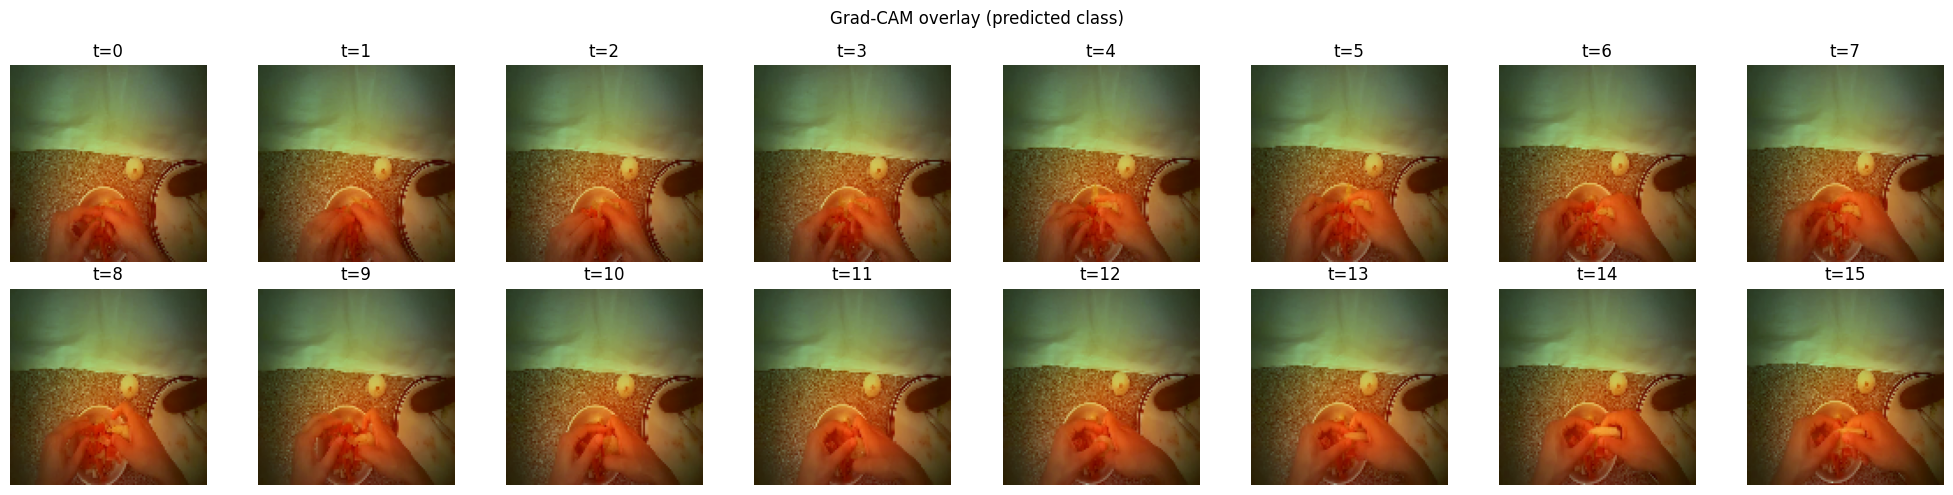

In [48]:
# KINETICS mean/std you already used (make sure these are the same tensors)
KINETICS_MEAN = torch.tensor([0.43216, 0.394666, 0.37645]).view(1, 3, 1, 1, 1)
KINETICS_STD  = torch.tensor([0.22803, 0.22145, 0.216989]).view(1, 3, 1, 1, 1)

# take one example
x, y, paths, metas = next(iter(test_loader))
x0 = x[0:1].to(DEVICE)
y0 = int(y[0].item())

# compute cam for predicted class (recommended for "what drove decision")
cam_tprime, pred_cls, logits = cam_extractor(x0, class_idx=None)
cam_16 = upsample_cam_to_input(cam_tprime, x0)  # (16,112,112)

pred_prob = torch.softmax(logits, dim=1)[0, pred_cls].item()
print("GT:", y0, "Pred:", pred_cls, "Pred prob:", pred_prob)
print("Path:", paths[0])
print("Meta:", metas[0])

# convert model input back to uint8 frames for visualization
frames = tensor_clip_to_uint8_frames(x0, KINETICS_MEAN, KINETICS_STD)

# overlay first 16 frames
overlays = []
cam_np = cam_16.detach().cpu().numpy()
for t in range(cam_np.shape[0]):
    overlays.append(overlay_cam_on_frame(frames[t], cam_np[t], alpha=0.5))

show_frames(overlays, title="Grad-CAM overlay (predicted class)")


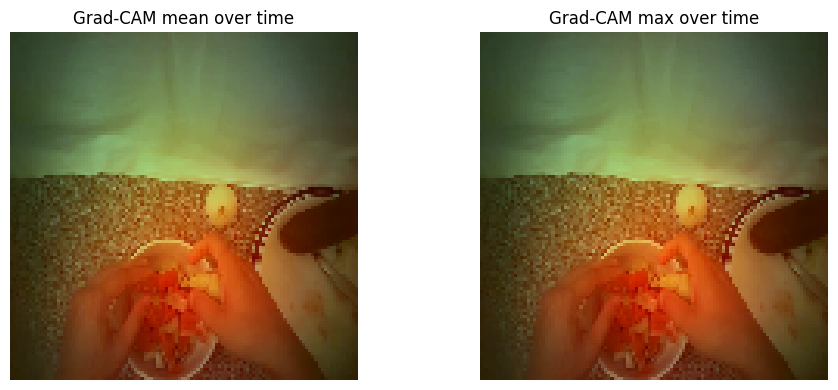

In [49]:
import numpy as np
import matplotlib.pyplot as plt

cam_np = cam_16.detach().cpu().numpy()  # (T,H,W)

cam_mean = cam_np.mean(axis=0)          # (H,W)
cam_max  = cam_np.max(axis=0)           # (H,W)

# pick a reference frame to overlay on (e.g., middle frame)
ref_t = cam_np.shape[0] // 2
ref_frame = frames[ref_t]               # (H,W,3) uint8

ov_mean = overlay_cam_on_frame(ref_frame, cam_mean, alpha=0.5)
ov_max  = overlay_cam_on_frame(ref_frame, cam_max,  alpha=0.5)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(ov_mean); plt.title("Grad-CAM mean over time"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(ov_max);  plt.title("Grad-CAM max over time");  plt.axis("off")
plt.tight_layout(); plt.show()


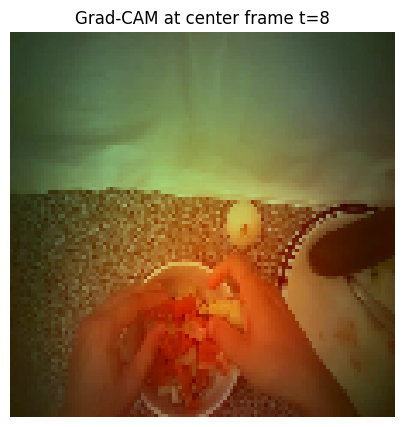

In [50]:
t_center = cam_np.shape[0] // 2
cam_center = cam_np[t_center]
ov_center = overlay_cam_on_frame(frames[t_center], cam_center, alpha=0.5)

plt.figure(figsize=(5,5))
plt.imshow(ov_center)
plt.title(f"Grad-CAM at center frame t={t_center}")
plt.axis("off")
plt.show()


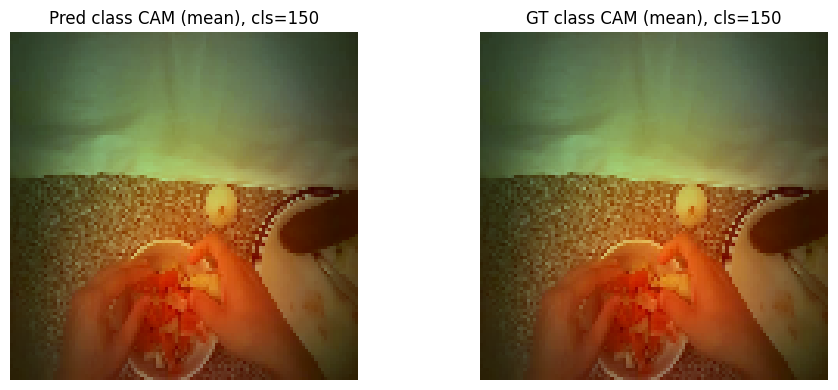

In [51]:
# pred cam already computed: cam_16 for pred_cls
cam_pred = cam_16

# compute cam for GT class
cam_tprime_gt, _, _ = cam_extractor(x0, class_idx=y0)
cam_gt = upsample_cam_to_input(cam_tprime_gt, x0)

cam_pred_np = cam_pred.detach().cpu().numpy()
cam_gt_np   = cam_gt.detach().cpu().numpy()

# aggregate over time (mean) to make single images
pred_mean = cam_pred_np.mean(axis=0)
gt_mean   = cam_gt_np.mean(axis=0)

ref_t = cam_pred_np.shape[0] // 2
ref_frame = frames[ref_t]

ov_pred = overlay_cam_on_frame(ref_frame, pred_mean, alpha=0.5)
ov_gt   = overlay_cam_on_frame(ref_frame, gt_mean,   alpha=0.5)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(ov_pred); plt.title(f"Pred class CAM (mean), cls={pred_cls}"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(ov_gt);   plt.title(f"GT class CAM (mean), cls={y0}"); plt.axis("off")
plt.tight_layout(); plt.show()


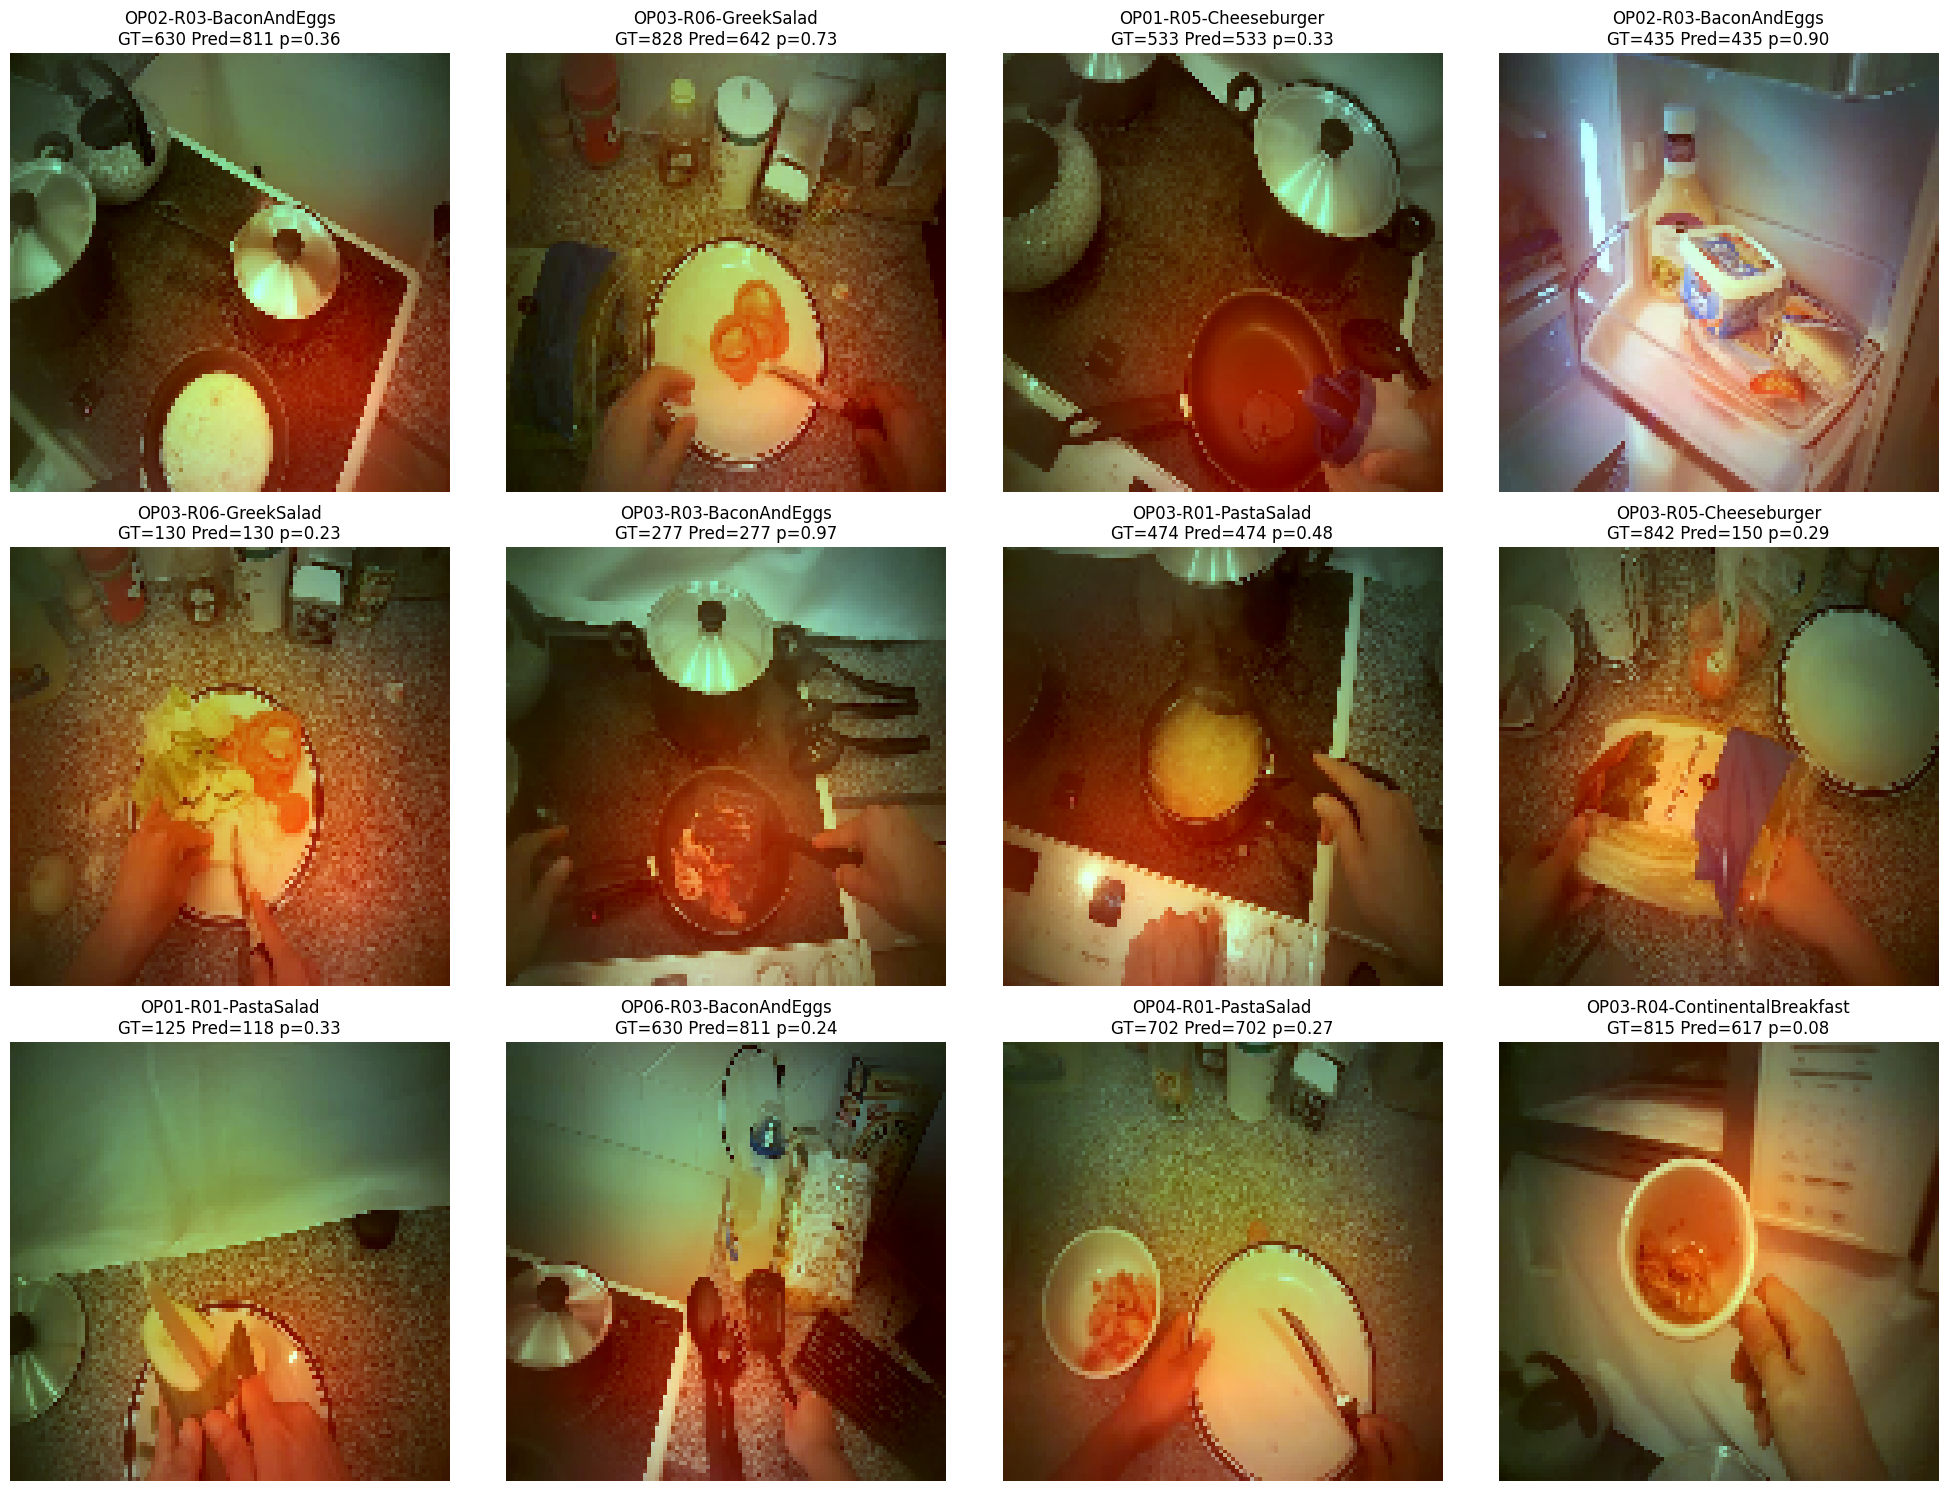

In [53]:
import random
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import torch

def show_random_diverse_from_dataset(ds, model, cam_extractor, N=12, seed=0, aggregate="mean"):
    rng = random.Random(seed)
    model.eval()

    idxs = list(range(len(ds)))
    rng.shuffle(idxs)
    idxs = idxs[:N]

    cols = 4
    rows = int(np.ceil(N / cols))
    plt.figure(figsize=(cols*5, rows*5))

    for k, idx in enumerate(idxs):
        x, y, path, meta = ds[idx]   # x:(3,T,H,W)
        x0 = x.unsqueeze(0).to(DEVICE)
        y0 = int(y.item())

        cam_tprime, pred_cls, logits = cam_extractor(x0, class_idx=None)
        cam_16 = upsample_cam_to_input(cam_tprime, x0)
        cam_np = cam_16.detach().cpu().numpy()
        cam_map = cam_np.mean(axis=0) if aggregate == "mean" else cam_np.max(axis=0)

        frames = tensor_clip_to_uint8_frames(x0, KINETICS_MEAN, KINETICS_STD)
        ref_t = frames.shape[0] // 2
        overlay = overlay_cam_on_frame(frames[ref_t], cam_map, alpha=0.5)

        prob = torch.softmax(logits, dim=1)[0, pred_cls].item()
        recipe = meta["video_id"]  # e.g., OP01-R01-PastaSalad

        plt.subplot(rows, cols, k+1)
        plt.imshow(overlay)
        plt.axis("off")
        plt.title(f"{recipe}\nGT={y0} Pred={pred_cls} p={prob:.2f}")

    plt.tight_layout()
    plt.show()

# Use train_ds or test_ds:
show_random_diverse_from_dataset(train_ds, model, cam_extractor, N=12, seed=42, aggregate="mean")
